In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cookie-cats/cookie_cats.csv


In [3]:
cookie_cats_path = '/kaggle/input/cookie-cats/cookie_cats.csv'
cookie_cats_data = pd.read_csv(cookie_cats_path)
cookie_cats_data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


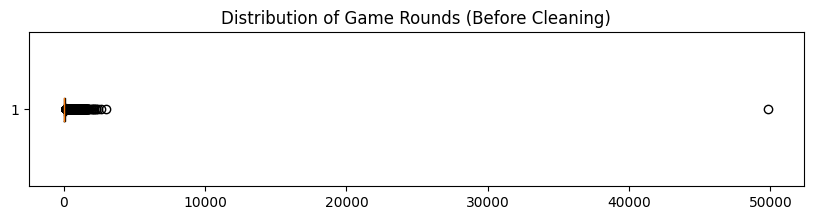

Max levels played: 49854

User Count per Group:
version
gate_40    45489
gate_30    44699
Name: count, dtype: int64


In [6]:
import matplotlib.pyplot as plt

# 1. Check for outliers in "sum_gamerounds"
# A boxplot will show us if someone played an insane number of levels
plt.figure(figsize=(10, 2))
plt.title("Distribution of Game Rounds (Before Cleaning)")
plt.boxplot(cookie_cats_data['sum_gamerounds'], vert=False)
plt.show()

# 2. Identify the "Super Whale" (The outlier)
print("Max levels played:", cookie_cats_data['sum_gamerounds'].max())

# 3. Remove the outlier
# (Usually, anyone with > 40,000 levels in 2 weeks is a bot or a bug)
cookie_cats_data_clean = cookie_cats_data[cookie_cats_data['sum_gamerounds'] < 3000].copy()

# 4. Count how many users are in each group (A/B)
print("\nUser Count per Group:")
print(cookie_cats_data_clean['version'].value_counts())

In [7]:

# 2. Calculate the Average Retention
# This tells us: "What % of players came back?"
results = cookie_cats_data.groupby('version')[['retention_1', 'retention_7']].mean()

print("--- The Scoreboard (Retention Rates) ---")
print(results)

# 3. Calculate the Difference
diff_1 = results.loc['gate_30', 'retention_1'] - results.loc['gate_40', 'retention_1']
diff_7 = results.loc['gate_30', 'retention_7'] - results.loc['gate_40', 'retention_7']

print(f"\nDifference in 1-Day Retention: {diff_1:.4f} ({(diff_1 * 100):.2f}%)")
print(f"Difference in 7-Day Retention: {diff_7:.4f} ({(diff_7 * 100):.2f}%)")

--- The Scoreboard (Retention Rates) ---
         retention_1  retention_7
version                          
gate_30     0.448188     0.190201
gate_40     0.442283     0.182000

Difference in 1-Day Retention: 0.0059 (0.59%)
Difference in 7-Day Retention: 0.0082 (0.82%)


This difference between groups is so miniscule it could be dismissed with "oh they had better players or pure luck". The goal is to show that this wasn't luck. For that we will need to perform a simulation.

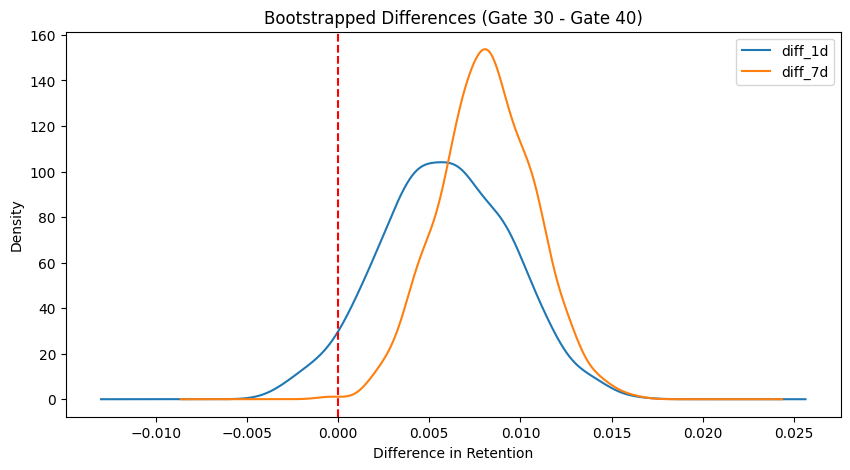

Probability that Gate 30 is better for 1-Day: 95.20%
Probability that Gate 30 is better for 7-Day: 99.80%


In [8]:
# --- STEP 3: BOOTSTRAPPING (Simulating the experiment 500 times) ---
boot_1d = [] # To store 1-day retention differences
boot_7d = [] # To store 7-day retention differences

# This loop checks "What if we re-ran the experiment?" 500 times
for i in range(500):
    # 1. Create a random sample of the data (with replacement)
    boot_mean = cookie_cats_data_clean.sample(frac=1, replace=True).groupby('version')[['retention_1', 'retention_7']].mean()
    
    # 2. Calculate the difference (Gate 30 - Gate 40)
    diff_1 = boot_mean.loc['gate_30', 'retention_1'] - boot_mean.loc['gate_40', 'retention_1']
    diff_7 = boot_mean.loc['gate_30', 'retention_7'] - boot_mean.loc['gate_40', 'retention_7']
    
    # 3. Store the results
    boot_1d.append(diff_1)
    boot_7d.append(diff_7)

# --- STEP 4: VISUALIZE & CALCULATE PROBABILITY ---
# Convert to a DataFrame for easy plotting
boot_df = pd.DataFrame({'diff_1d': boot_1d, 'diff_7d': boot_7d})

# Plot the distribution of the differences
# (If the curve is mostly to the RIGHT of 0, Gate 30 is definitely better)
ax = boot_df.plot(kind='kde', figsize=(10, 5))
ax.set_title('Bootstrapped Differences (Gate 30 - Gate 40)')
ax.set_xlabel('Difference in Retention')
plt.axvline(0, color='red', linestyle='--') # The "Zero Difference" line
plt.show()

# --- THE FINAL VERDICT (Probability) ---
# What is the % chance that Gate 30 is actually better?
# We count how many times the difference was > 0
prob_1d = (boot_df['diff_1d'] > 0).mean()
prob_7d = (boot_df['diff_7d'] > 0).mean()

print(f"Probability that Gate 30 is better for 1-Day: {prob_1d:.2%}")
print(f"Probability that Gate 30 is better for 7-Day: {prob_7d:.2%}")